In [1]:
## Imports

import csv
import numbers
import os
import random
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path
from typing import *

import flwr as fl
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337

np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False # type: ignore
torch.backends.cudnn.deterministic = True # type: ignore

def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    config,
    strategy,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        config=config,
        strategy=strategy,
    )

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf)

PathType = Optional[Union[Path, str]]



def get_device() -> str:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

In [2]:
home_dir = Path(os.getcwd())
# home_dir = Path("/Users/lorenzosani/My drive (ls985@cam.ac.uk)/Teaching/FL_2022-2023/")
dataset_dir: Path = home_dir / "femnist"
# dataset_dir = Path("/Users/lorenzosani/tmp/femnist/femnist")
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

In [7]:
#  Download compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist.tar.gz"),
    )
    
# Decompress dataset 
if not dataset_dir.exists():
  !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
  print(f"Dataset extracted in {dataset_dir}")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-
To: c:\Users\miran\Desktop\gnn-assisted-fl\femnist.tar.gz
100%|██████████| 223M/223M [00:12<00:00, 17.6MB/s]


We also need the dataset object. We will use the same as in the previous lab.

In [4]:
if not (home_dir / "femnist_dataset.py").exists():
    id = "11xG4oIhdbVcDtXxbS2ZosDSJYAC0iL7q"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist_dataset.py"),
    )
if not (home_dir / "client.py").exists():
    id = "11xRc__g3iMOBRiQsPr9mDor5Ile_Pude"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client.py"),
    )
if not (home_dir / "client_utils.py").exists():
    id = "121UMOA7kg96rrZBe7vwt-2vgc-sTGu-X"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client_utils.py"),
    )

In [ ]:
from femnist_dataset import FEMNIST

### 2.1 Feature distribution skew

Statisticians and data scientists refer to this property as "covariate shift”. It happens when different clients present samples which describe ideally the same objects having slightly different features. That is the case for two different writers hand-writing the same word, since these may have different stroke widths, slants, etc.
What happens to an FL setting in which this property is strong is not always predictable. Ideally, the global model, obtained using FedAvg, will try to learn a shared representation between clients. This could be problematic since clients have different features to represent their data. We could simply expect that the same seed model trained separately on local clients may perform better than a global model obtained in an FL training.

To see this property in our chosen dataset we will show two images for the same number taken from different clients.
*NOTE: the choice of clients and samples in the following is not random, but suitably made to show you the property.*

In [6]:
client_0_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition/'0',
    data_dir=data_dir,
    name='train'
    )
client_1000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition/'1000',
    data_dir=data_dir,
    name='train'
    )
img_A, label_A = client_0_dataset[4]
img_B, label_B = client_1000_dataset[0]

print(f"For client 0, sample 4 has label {label_A}")
print(f"For client 1000, sample 0 has label {label_B}")
# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

ValueError: Required files do not exist, path: c:\Users\miran\Desktop\gnn-assisted-fl\femnist\client_data_mappings\fed_natural\0\train.csv

We can also compare the average values of all the features for all the samples of these clients having the label chosen. You can try to execute the cell below choosing different labels.

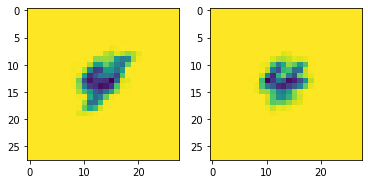

In [ ]:
label_chosen = 4
features_0 = []
for img, lbl in client_0_dataset:
  if lbl == label_chosen:
    features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
  if lbl == label_chosen:
    features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow((np.sum(features_0, axis=0)/len(features_0)).reshape((28,28)))
ax[1].imshow((np.sum(features_1000, axis=0)/len(features_1000)).reshape((28,28)))

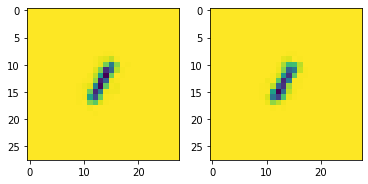

In [ ]:
label_chosen = 1
features_0 = []
for img, lbl in client_0_dataset:
  if lbl == label_chosen:
    features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
  if lbl == label_chosen:
    features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow((np.sum(features_0, axis=0)/len(features_0)).reshape((28,28)))
ax[1].imshow((np.sum(features_1000, axis=0)/len(features_1000)).reshape((28,28)))

It is worth having a glance on what are the consequences of this property on an FL experiment. To do that we will re-use the code for training an FL client from the previous lab.

The following cell is thus meant to import objects and methods you have already used in the previous lab. There's nothing new in the cell below.

In [ ]:
from client_utils import to_tensor_transform, get_network_generator_mlp, get_network_generator_cnn, get_model_parameters, Net, get_federated_evaluation_function, aggregate_weighted_average
from client import FlowerRayClient, get_flower_client_generator

In order to show on a small scale what can happen to FL training setups where clients have feature distribution skew, we will now build two toy settings. We choose the most populated client---the one with the most samples in the federation. We will then construct a second version of this same client by artificially changing its features by inverting the underlying images--- transforming each image into its negative. Furthermore, we need a specific `get_flower_client_generator` able to invert the images of a specific client.

In the following, we provide the relevant methods to do that. These methods are simplified taking advantage of the federation being composed of just two clients.

In [ ]:
def load_FEMNIST_inverted_dataset(mapping: Path, name: str) -> Dataset:
    """Function to load the filterd FEMNIST dataset given the mapping .csv file.
    The relevant transforms are automatically applied.
    Note that the last transform will invert images, getting their negative representation.

    Args:
        mapping (Path): path to the mapping .csv file chosen.
        name (str): name of the dataset to load, train or test.

    Returns:
        Dataset: FEMNIST dataset object, ready to use.
    """
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.functional.invert,
        ]
    )

    return FEMNIST(
        mapping=mapping,
        name=name,
        data_dir=data_dir,
        transform=transform,
        target_transform=to_tensor_transform)

def _load_inverted_dataset(self, name) -> Dataset:
    full_file: Path = self.partition_dir / str(self.cid)
    return load_FEMNIST_inverted_dataset(
        mapping=full_file,
        name=name)
    
def get_mod_flower_client_generator(
  model_generator: Callable[[], Module],
  data_dir: Path,
  partition_dir: Path,
  mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.
    Note that the "even" clients here will have a modified `_load_dataset` function.
    The new `_load_dataset` has been chosen to be the one inverting the images.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """
    def client_fn(cid: str) -> FlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClient: client instance.
        """
        print(f"Getting client with id {cid}")
        actual_cid = mapping_fn(int(cid)) if mapping_fn is not None else int(cid)
        client = FlowerRayClient(
            cid=actual_cid,
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        client.device = get_device()
        # Pay attention to the following two lines
        if int(cid)%2 == 0:
          client._load_dataset = _load_inverted_dataset.__get__(client, FlowerRayClient)
        return client

    return client_fn

We will now try to train separately the two clients generated this way. The mapping function will be provided to point both client IDs to the data of the most populated client.
```python
mapping_dict = {0: '178', 1: '178'}
```
*NOTE: you may want _to experiment _with _different__ clients here_. After having completed the lab, feel free to try!*

The following cell will set the relevant configuration for both training and testing of the client and its inverted version.

**IMPORTANT: the architecture used here is an MLP because it is affected by inversion of images.**

In [ ]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_mlp = get_network_generator_mlp()
seed_net_mlp = network_generator_mlp()
seed_model_mlp_params: NDArrays = get_model_parameters(seed_net_mlp)
train_config: Dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
}
# NOTE: this dict will be used as it is for the rest of the notebook
test_config: Dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 2,
}
# Here is the mapping
mapping_dict = {0: '178', 1: '178'}
# NOTE: we are using here the `get_mod_flower_client_generator`
federated_mod_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_mod_flower_client_generator(network_generator_mlp, data_dir, federated_partition, mapping_fn=lambda x: mapping_dict[x]) # type: ignore
# NOTE: we are using here the `get_flower_client_generator`
federated_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(network_generator_mlp, data_dir, federated_partition, mapping_fn=lambda x: mapping_dict[x]) # type: ignore

Let's train separately the two versions of the client and then mutually evaluate their models.

In [ ]:
# creating clients
client_0 = federated_mod_flower_client_generator(0)
client_1 = federated_mod_flower_client_generator(1)
# fitting client 0
client_0_params, *rest = fit_client_seeded(client_0, seed_model_mlp_params, train_config)
print(f'Results of fitting the seed model on client 0:\n\t{rest}')
# evaluating client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_0_params, test_config)
print(f'Results of evaluating model trained on client 0 on the test set of client 0:\n\t{client_0_res}')
# fitting client 1
client_1_params, *rest = fit_client_seeded(client_1, seed_model_mlp_params, train_config)
print(f'Results of fitting the seed model on client 1:\n\t{rest}')
# evaluating client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_1_params, test_config)
print(f'Results of evaluating model trained on client 1 on the test set of client 1:\n\t{client_1_res}')


# evaluating client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_1_params, test_config)
print(f'Results of evaluating model trained on client 1 on the test set of client 0:\n\t{client_0_res}')
# evaluating client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_0_params, test_config)
print(f'Results of evaluating model trained on client 0 on the test set of client 1:\n\t{client_1_res}')

Getting client with id 0
Getting client with id 1


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Results of fitting the seed model on client 0:
	[13, {'train_loss': 0.04750089146769964}]


100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Results of evaluating model trained on client 0 on the test set of client 0:
	(6.324357986450195, 2, {'local_accuracy': 0.5531914893617021})


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Results of fitting the seed model on client 1:
	[13, {'train_loss': 0.1156758448252311}]


100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


Results of evaluating model trained on client 1 on the test set of client 1:
	(7.643922567367554, 2, {'local_accuracy': 0.14893617021276595})


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Results of evaluating model trained on client 1 on the test set of client 0:
	(7.991089820861816, 2, {'local_accuracy': 0.14893617021276595})


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

Results of evaluating model trained on client 0 on the test set of client 1:
	(64.07830429077148, 2, {'local_accuracy': 0.0})


In the following cell, we will set up all the relevant methods and parameters to run an FL simulation.

In [ ]:
on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config
accept_failures = False
server_learning_rate = 1.0
min_fit_clients = 2
min_evaluate_clients = 2
min_available_clients = 2
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_mlp_params)
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
}

In [ ]:
on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config
# NOTE: we don't need the `federated_evaluation_function` because we care about
# the distributed accuracy.
strategy = FedAvg(
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=on_fit_config_fn,
    on_evaluate_config_fn=on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    server_learning_rate=server_learning_rate,
)

**Question 1 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)


1. Using the methods implemented so far, set up two FL settings composed of the clients above. One has both clients with their original dataset, and the other has one client with their features inverted. *(Hint: use `federated_flower_client_generator` for the first setting and `federated_mod_flower_client_generator` for the second setting)*
2. Train the two settings generated at 1) for 5 rounds using `fl.simulation.start_simulation`. Set `num_clients=2` to use only client IDs in `[0,1]`. Use the `strategy` from the cell above.
3. Take note of the evaluation metrics of both FL experiments that you have done. Compare the two using those metrics (plots are recommended). Briefly discuss the results.

### 2.2 Label distribution skew

The flavour of data heterogeneity we are dealing with in this subsection is often called “prior probability shift". In a few words, this occurs when, given a particular label, the distribution of samples having that label differs from client to client. In our running example, we can see whether in FEMNIST happens that different clients have drawn different distributions of symbols.
We can think about what could happen to an FL training in this situation simplifying a bit the actors in a play. Let's imagine that the federation has a subset of clients (one client: client 0) that is the only one having a specific subset of labels (say letters). A global model trained using FedAvg on that federation won't ever be able to learn well the representation of that subset of labels (letters). There exist methods to mitigate this particular situation, but often they involve sharing statistics about local datasets, thus creating privacy concerns.

We will select two clients, then we will plot the histogram of the labels for each of them on the same canvas. Thus, we will be able to evaluate whether there is a qualitative difference between the two.

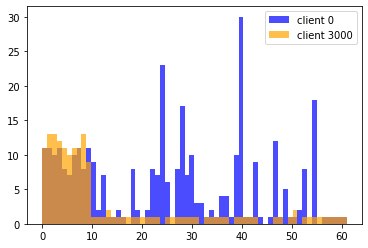

In [ ]:
client_3000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition/'3000',
    data_dir=data_dir,
    name='train'
    )
plt.hist([int(x[1]) for x in client_0_dataset], bins=62, color="blue", alpha=0.7, label="client 0")
plt.hist([int(x[1]) for x in client_3000_dataset], bins=62, color="orange", alpha=0.7, label="client 3000")
plt.legend()

**Question 2 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. If we ignore the privacy assumption of FL and allow the overall label distribution to be known, how could we balance the set of selected clients to guide the federated model towards a similar per-class accuracy that the centralised model can achieve? Assume FedAvg and the usual client implementation in your reasoning.
2. Can you design an automatic data-driven procedure to mitigate label skew? Assume you are operating on a client level, keeping data private, and using standard FedAvg with random client selection. 

### 2.3 Quantity skew

The last kind of heterogeneity we will discuss in detail is the *quantity skew*, which occurs when clients possess different numbers of samples. Last, but not least, it is the most investigated property that real FL datasets have. Also called “unbalancedness", it has been tackled using many techniques spanning from data manipulation to optimization algorithm design. Even if the literature regarding such techniques is quite broad, relative to FL being a new topic of research, there is still not any agreement about how to deal with unbalancedness. Often different solutions have different accuracy depending on the task and how unbalanced the FL dataset is.

Those of you that have well-trained observation skills may recall a plot in the last lab that spoiled this property. Now we'll try to get the global view of FEMNIST data from this perspective.

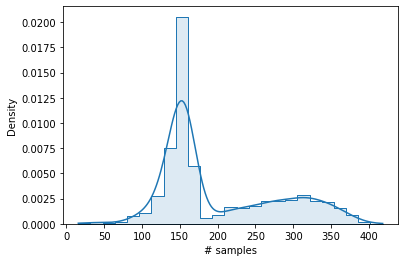

In [ ]:
sns.histplot(
    alpha=0.15,
    legend=True,
    data=[len(FEMNIST(
    mapping=federated_partition/str(i),
    data_dir=data_dir,
    name='train'
    )) for i in range(3229)],
    fill=True,
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
    common_bins=True,
    cbar=True,
    palette="dark",
)
plt.xlabel("# samples")
plt.show()

**Question 3 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. How does the FedAvg weighting strategy interact with quantity skew?
2. What would you change in the weighting strategy of FedAvg in order to make it fairer towards clients with few samples?

# 3. The behaviour of FL under data heterogeneity/creating heterogeneous partitions



## FEMNIST folder structure



By default, FEMNIST will be split as follows:

- `femnist`: the location of the relevant data
  - `client_data_mappings`: contains different partitions
    - `centralized`: mappings from writer_id -> `[image_path, label]` for the centralized dataset
    - `fed_natural`: mappings from writer_id -> `[image_path, label]` for the naturally federated dataset
  - `data`: contains the macro partitions between test, train, and val
    - `train`: contains the raw images---samples of the train set
    - `test`: contains the raw images---samples of the test set
    - `val`: contains the raw images---samples of the val set
- `femnist.tar.gz`: the compressed dataset

We will store client datasets in sequentially labelled folders within each partition and do all necessary remapping in python.

In [ ]:
# Showing resulting folder tree
! tree -dC -L 3 ./

./
├── femnist
│   ├── client_data_mappings
│   │   ├── centralized
│   │   ├── class_unbalanced
│   │   └── fed_natural
│   └── data
│       ├── test
│       ├── train
│       └── val
├── __pycache__
└── sample_data

11 directories


## Test sets for FL

Prior to constructing our centralized partition, it is necessary to discuss what a test set even means for FL.

A testing set can generally be either a **federated test set** or a **local test set**: 

- A federated test set contains data representative of the entire federated network and is used to provide a form of centralized-like evaluation of the federated model. In production scenarios, this would be data that has been consensually gathered from a multitude of users and is legal/efficient to store on the server or clients which have been kept out of the training loop. For research purposes it can be constructed in one of the two following ways:
  - Take x% of data from all clients and save it separately. 
  - Leave y% of clients utterly unavailable for federated training and use their data as a test/validation set. **This is the version we shall use during the lab for the federated test set.**
- A local test set is formed via data from a specific client which has not been seen during training. There are as many local test sets as there are clients. As such, they can be used to test the model on a specific client or to accumulate average statistics to determine its performance.

## Creating and using partitions

### Class unbalancedness

We will start creating class unbalanced partitions. The most representative example, as often happens, is the extreme one. Thus, we are going to create a partition of the dataset in which each client possesses one class only. This aim sets one parameter for the creation of the current partition, but we need to choose also another parameter: the number of clients we want to create or the number of samples per client that we want to infer. These last are two antagonist parameters that describe the same thing. The larger the number of clients is, the lower the number of samples per client is.

Let's start by looking at how labels are distributed in the entire dataset (test set only), by treating the dataset as centralized.

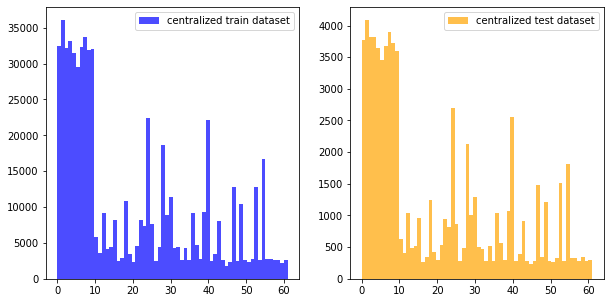

In [ ]:
centralized_train_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition/'0',
    data_dir=data_dir,
    name='train'
    )
centralized_test_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition/'0',
    data_dir=data_dir,
    name='test'
    )
fig, ax = plt.subplots(1,2,figsize=(10,5))
train_histo = ax[0].hist([int(x[1]) for x in centralized_train_dataset.data], bins=62, color="blue", alpha=0.7, label="centralized train dataset")
test_histo = ax[1].hist([int(x[1]) for x in centralized_test_dataset.data], bins=62, color="orange", alpha=0.7, label="centralized test dataset")
ax[0].legend()
ax[1].legend()

Since the distribution is all but uniform, we need to make a further choice. We want to build a federation of 62 clients each of them having one class only. We want all the classes to be represented in the federation. Likewise, we also want FedAvg to treat equally all the clients in the federation. Thus, we will need to partition clients taking into account the population of the least represented class in both the `train` and the `test` set.

In [ ]:
print(f'The least represented class in the train set has {min(train_histo[0])} samples')
print(f'The least represented class in the test set has {min(test_histo[0])} samples')
max_train_samples = int(min(train_histo[0]))
max_test_samples = int(min(test_histo[0]))

The least represented class in the train set has 1786.0 samples
The least represented class in the test set has 233.0 samples


Let's now create the function that creates the partition. We will stick to the folder structure the dataset has.

In [ ]:
class_unbalanced_partition: Path = dataset_dir / 'client_data_mappings' / 'class_unbalanced'
class_unbalanced_partition.mkdir(parents=True, exist_ok=True)
train_df = pd.read_csv(centralized_mapping/'train.csv')
test_df = pd.read_csv(centralized_mapping/'test.csv')
max_train_samples = 200
max_test_samples = 50
for i in range(62):
  folder_path: Path = class_unbalanced_partition / str(i)
  folder_path.mkdir(parents=True, exist_ok=True)

  train_path: Path = folder_path / "train.csv"
  test_path: Path = folder_path / "test.csv"

  client_df = deepcopy(train_df[train_df.label == i].sample(frac=1)[:max_train_samples]).reset_index()
  client_df['client_id'] = i
  client_df.drop(columns=['level_0'], inplace=True)
  client_df.to_csv(train_path, index=False)
  client_df = deepcopy(test_df[test_df.label == i].sample(frac=1)[:max_test_samples]).reset_index()
  client_df['client_id'] = i
  client_df.drop(columns=['level_0'], inplace=True)
  client_df.to_csv(test_path, index=False)

In [ ]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)

In [ ]:
# NOTE: the functions in this cell will be used as they are for the rest of the notebook
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

In [ ]:
# NOTE: these parameters will have the same value for the rest of the notebook
accept_failures = False
server_learning_rate = 1.0
min_fit_clients = 2
min_evaluate_clients = 0
min_available_clients = 2
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
    "num_cpus": 1.0, # num_clients_per_round,
}

In [ ]:
unbalanced_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(network_generator_cnn, data_dir, class_unbalanced_partition) # type: ignore

In [ ]:
train_config: Dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
}

on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config

num_total_clients = 62
num_clients_per_round: int = 3
num_evaluate_clients: int = 1
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

strategy = FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=on_fit_config_fn,
    on_evaluate_config_fn=on_evaluate_config_fn,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    server_learning_rate=server_learning_rate,
)

In [ ]:
hist = start_seeded_simulation(
    client_fn=unbalanced_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flwr 2023-02-17 16:02:43,644 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-02-17 16:02:50,367	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-02-17 16:02:52,900 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'object_store_memory': 3994182451.0, 'memory': 7988364903.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'object_store_memory': 3994182451.0, 'memory': 7988364903.0}
INFO flwr 2023-02-17 16:02:52,907 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-02-17 16:02:52,916 | server.py:266 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO fl

**Question 4 (Part II ✅ | Part III/MPhil ✅):**

(This is meant to be a conceptual question. You should provide a written answer to this. **No more than 3 sentences**. **No code** is needed)

1. Can you give any explanation about the result of the previous experiment? Why do you think the accuracy is so bad?

**Question 5 (Part III/MPhil ✅):**

(This is meant to be a conceptual question. You should provide a written answer to this. **No more than 3 sentences**. **No code** is needed)

1. How does the concept of a client relate to a task in Multi-task Learning (MTL)?


### LDA partitions

The most popular method for creating heterogeneous partitions from a centralized dataset in terms of class unbalancing is [Latent Dirichlet Allocation (LDA)](https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html). LDA is a generative probabilistic model for collections of discrete data. The paper linked above provides all the theoretical details about the method. 

The important detail for you to understand about LDA is that the `concentration` parameter controls the degree of heterogeneity in the distribution while `num_partitions` controls how many clients are generated following the specified distribution. 

A `concentration=0` implies a completely heterogeneous distribution where each client may only contain examples from one class. Thus, if for a `concentration=0` we were to set the `num_partitions` argument to the number of classes we will get the same partitioning as the one we manually created above. 

**Important:** The LDA partitioning only approaches a fully i.i.d distribution when `concentration` tends towards $\infty$. In our code, we shall use `99999` to represent $\infty$.

In [ ]:
!wget https://raw.githubusercontent.com/adap/flower/v1.0.0/baselines/flwr_baselines/dataset/utils/common.py -O lda_utils.py

In [ ]:
from lda_utils import create_lda_partitions

In [ ]:
concentration = 2.5
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x,y),
    dirichlet_dist=None,
    num_partitions=3229,
    concentration=concentration,
    accept_imbalanced=True,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x,y),
    dirichlet_dist=dist,
    num_partitions=3229,
    concentration=concentration,
    accept_imbalanced=True,
)

In [ ]:
lda_partition: Path = dataset_dir / 'client_data_mappings' / 'lda'
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(zip(train_clients_partitions, test_clients_partitions)):
  folder_path: Path = lda_partition / str(i)
  folder_path.mkdir(parents=True, exist_ok=True)

  train_path: Path = folder_path / "train.csv"
  test_path: Path = folder_path / "test.csv"

  pd.DataFrame({'client_id': [0]*len(train_set[0]),
              'sample_path': train_set[0],
              'sample_id': range(len(train_set[0])),
              'label': train_set[1]}).to_csv(train_path, index=False)
  pd.DataFrame({'client_id': [0]*len(test_set[0]),
              'sample_path': test_set[0],
              'sample_id': range(len(test_set[0])),
              'label': test_set[1]}).to_csv(test_path, index=False)

In [ ]:
lda_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(network_generator_cnn, data_dir, lda_partition) # type: ignore

In [ ]:
plt.hist([int(x[1]) for x in lda_flower_client_generator(0)._load_dataset('train').data], bins=62, color="blue", alpha=0.7, label="client 0 train set")
plt.hist([int(x[1]) for x in lda_flower_client_generator(1)._load_dataset('train').data], bins=62, color="orange", alpha=0.7, label="client 1 train set")
plt.legend()

In [ ]:
train_config: Dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
}

on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config

num_total_clients = 3229
num_clients_per_round: int = 3
num_evaluate_clients: int = 1
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

strategy = FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=on_fit_config_fn,
    on_evaluate_config_fn=on_evaluate_config_fn,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    server_learning_rate=server_learning_rate,
)

In [ ]:
hist = start_seeded_simulation(
    client_fn=lda_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
)

**Question 6 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Produce a set of LDA partitions with `concentration` in `[0.1, 1.0, 99999]`.
2. Train an FL setting for every partition you have produced using the same hyperparameter we used in the cell above, but with `num_clients_per_round=15` and `ServerConfig(num_rounds=1)`.
3. Why do you think one-shot averaging works well for full i.i.d data and not for very heterogeneous clients?

**Question 7 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Use the previous set of LDA partitions with `concentration` in `[0.1, 1.0, 99999]`.
2. Train an FL setting for every partition you have produced using the same hyperparameter we used in the cell above---with `num_clients_per_round=3` and `ServerConfig(num_rounds=5)`.
3. Compare the final accuracy of the trained FL settings in a graph.
4. How should the amount of local work relative to aggregation rounds change as heterogeneity increases? Take into account the results from question 6 as well.

# 4. FL Strategies tackling heterogeneity


The challenge of dealing with non-iidness in FL has been discussed extensively since the publication of the first paper about FL. Many approaches have been proposed, but still, the literature doesn't agree on a general approach or a rule of thumb. A natural method is to modify/extend FedAvg or develop another algorithm specifically oriented to mitigating heterogeneity. In some applications, augmenting data to make it more similar between clients is possible. Some works assume a small dataset that is shared between clients to serve as a reference. 

Every time a new approach has been proposed, many related questions have arisen. It is no longer clear that treating all examples of all the clients equally make sense. Some works proposed limiting the contributions of data from any client in the federation. The notion of fairness has been introduced and defined in many ways in order to set up principles that could result in new approaches, for example emphasizing underperforming clients during aggregation. It is not even clear whether a single global model is the correct objective for FL---works related to this question gave birth to Personalised Federated Learning (PFL), a sub-branch of research.

We started to think that we should be able to turn the non-iid problem from a bug into a feature treated similarly to a task in MTL. The number of works that start with this perspective is however limited.

Even if FedAvg can partially mitigate heterogeneity, it is not working well in all situations, as we saw previously. From the many new algorithms that were introduced, it is worth mentioning: [FedProx](https://www.researchgate.net/profile/Anit-Sahu/publication/329734586_On_the_Convergence_of_Federated_Optimization_in_Heterogeneous_Networks/links/5c1bdd5e299bf12be38ee52d/On-the-Convergence-of-Federated-Optimization-in-Heterogeneous-Networks.pdf), [q-FedAvg](https://arxiv.org/abs/1905.10497), [SCAFFOLD](http://proceedings.mlr.press/v119/karimireddy20a.html). For a matter of time, we will now explore just one of these algorithms introduced for tackling the non-iid problem specifically. We chose FedProx since it is the simplest to demonstrate.

## FedProx

The Federated Proximal (FedProx) method was developed in the context of tuning and benchmarking FedAvg in a heterogeneous setting. The authors of FedAvg proposed carefully tuning the learning rate and the number of local epochs to increase the accuracy in such settings but turned out clear that something more was necessary. Based on the client's heterogeneity, local updates change the global model not only in different directions in the loss space but also at different rates. This phenomenon is called client divergence or drifting. 

Using FedAvg we would like to have a different number of local epochs for each client based on its characteristics. Thus, heuristically setting the number of local updates is not always optimal, because clients are all different from each other. Limiting the number of local updates through a more flexible tool is beneficial. Thus, FedProx proposes to incorporate a term in the local objective function that penalizes big changes from the current model at the server. In each node $k$, instead of minimizing the local loss function $F_k$, the local solver tries to approximately minimize:

$\min_wh_w(w;w^t)=F_k(w)+\frac{\mu}{2}||w-w^t||^2$,

where $||w-w^t||^2$ is the new proximal term. 

FedProx acts as FedAvg apart from the change in the local objective. This new objective enforces limited local model updates more explicitly than FedAvg. Using FedProx, it is no longer necessary to tune the number of local epochs for each client to minimize divergence.

We will now implement and test FedProx on the natural partition of FEMNIST. Implementing FedProx just involves modifying the local training function of our `FlowerRayClient`. We will then write the new function and build a new `client_generator` function that overwrites the relevant methods of our client.

In [ ]:
def train_fedprox_FEMNIST(
  net: Module,
  train_loader: DataLoader,
  epochs: int,
  device: str,
  optimizer: torch.optim.Optimizer,
  criterion: Module,
  proximal_mu: float,
) -> float:
    """Trains the network on the training set using FedProx.

    Args:
        net (Module): generic module object describing the network to train.
        train_loader (DataLoader): dataloader to iterate during the training.
        epochs (int): number of epochs of training.
        device (str): device name onto which perform the computation.
        optimizer (torch.optim.Optimizer): optimizer object.
        criterion (Module): generic module describing the loss function.
        proximal_mu (float): parameter for the weight of the proximal term.

    Returns:
        float: the final epoch mean train loss.
    """
    global_params: Module = deepcopy(net)
    global_params.requires_grad_(False)
    global_params = [val for _, val in global_params.state_dict().items()]
    net.train()
    running_loss, total = 0.0, 0
    for _ in tqdm(range(epochs)):
        running_loss = 0.0
        total = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # NOTE: here comes the implementation of FedProx algorithm
            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(data), labels) + (proximal_mu / 2) * proximal_term
            running_loss += loss.item()
            total += labels.size(0)
            loss.backward()
            optimizer.step()
    return running_loss/total

def _train_fedprox(
    self, net: Module, train_loader: DataLoader, config: Dict[str, Scalar]
) -> float:
    return train_fedprox_FEMNIST(
        net=net,
        train_loader=train_loader,
        epochs=int(config["epochs"]),
        device=self.device,
        optimizer=torch.optim.AdamW(
            net.parameters(),
            lr=float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"]),
        ),
        criterion=torch.nn.CrossEntropyLoss(),
        proximal_mu=config['proximal_mu'],

    )


def get_fedprox_flower_client_generator(
  model_generator: Callable[[], Module],
  data_dir: Path,
  partition_dir: Path,
  mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.
    The clients genrated will train using FedProx algorithm.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """
    def client_fn(cid: str) -> FlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClient: client instance.
        """
        print(f"Getting client with id {cid}")
        actual_cid = mapping_fn(int(cid)) if mapping_fn is not None else int(cid)
        client = FlowerRayClient(
            cid=actual_cid,
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        client.device = get_device()
        # Pay attention to the following line
        client._train = _train_fedprox.__get__(client, FlowerRayClient)
        return client

    return client_fn

We are now able to train an FL setting using FedProx.

In [ ]:
# NOTE: we are using here the `get_fedprox_flower_client_generator`
federated_fedprox_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_fedprox_flower_client_generator(network_generator_cnn, data_dir, lda_partition) # type: ignore

train_config: Dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "proximal_mu": 0.01,
}

on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config

num_total_clients = 3229
num_clients_per_round: int = 3
num_evaluate_clients: int = 1
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

strategy = FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=on_fit_config_fn,
    on_evaluate_config_fn=on_evaluate_config_fn,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    server_learning_rate=server_learning_rate,
)

In [ ]:
hist = start_seeded_simulation(
    client_fn=federated_fedprox_flower_client_generator,
    num_clients=3229,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=10),
    strategy=strategy,
)

**Question 8 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Train the FL setting composed of LDA partitions with `concentration=5` using FedProx with values of `proximal_mu` in $\{0.0, 0.1\}$. Keep `num_clients_per_round=3` and `ServerConfig(num_rounds=10)`.
2. Plot convergence curves for both `proximal_mu`.


**Question 9 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Assume to have fixed `num_clients_per_round*num_rounds≈30` and `local_epochs=8`. What combination of `num_clients_per_round` and `num_rounds` should result in the largest gap between FedProx with `proximal_mu=0.01` and `proximal_mu=0.0`? Try at least two combinations you think are likely to be best. We recommend values of `num_clients_per_round` in the interval $[3,10]$.
2. Based on the results in (1), what do you think is a reasonable rule of thumb for setting the `num_clients_per_round` and `num_rounds` of FedProx in a non-iid setting?

**Question 10 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. No code is needed)

In FL, fairness is generally defined as the variance of the accuracy of the global model on local clients' test sets. If two models have the same average accuracy, the one with the lower variance between clients is the fairer.

- In light of this, is it reasonable to say that analysing the fairness of the model across clients, i.e. the distributed accuracy, could be used as a tool to measure the data heterogeneity? Motivate your answer.
- Both FedAvg and FedProx are training a single global model, so we will always measure some unfairness. Do you think we could improve fairness by finetuning the global model on the local clients just before evaluating it on their local test set?

Regularization terms such as the one used by FedProx are varied, the one used by FedProx is meant to be efficient. As such, it only increases memory usage and computation by $O(M)$ where $M$ is the model size. While simple, this approach is blind to the **meaning** of a parameter in terms of how it influences the output distribution of the network. 

An alternative regularization method which only increases the complexity of the implementation by a minimal amount is [Knowledge Distillation](https://arxiv.org/pdf/1503.02531.pdf). The teacher network shall be the copy of the federated model from the start of the round and the student network will be the currently training federated model of the client. 

This method looks at the distribution of outputs from the two networks on local batches. It works by constraining the divergence of parameters important to matching the output distribution of the teacher with that of the client model. In the following question you will compare this with the way FedProx constrains all parameters in the same manner. 

**Question 11 (Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)
1. Implement Knowledge Distillation as a regularization method in the same manner as we implemented FedProx above. You will have to:
    - Deepcopy the parameters of the federated model at the start of a round. Make sure to freeze the model as to avoid training it.
    - Compute the outputs of the teacher and student for each batch.
    - Add the [KL divergence](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html) between the outputs of the teacher and the outputs of the student to the normal cross-entropy loss of the student. Use a parameter $\alpha$ to control the two losses as follows:
    - $L(C,x) = (1-\alpha) L(C,x) + \alpha K_l(\sigma(G(x)), \sigma(C(x))) $
    - Where $L(C,x)$ is the cross-entropy of the client model $C$ with respect to input x, $K_l$ is the aforementioned divergence, $\sigma$ is the softmax activation function and $G(x)$ is the output of the teacher model while $C(x)$ is the output of the student model.
2.  Compare FedAvg with Knowledge Distillation with the previously tested parameters of FedProx keeping everything else the same, try $\alpha \in \{0,0.1,0.5\}$. Plot FedProx and FedAvg-with-KD on the same graph for all hyperparameters.